**DỰ ĐOÁN SINH VIÊN BỎ HỌC**

Project này tunning 2 mô hình Ensemble Learning là XGBoost và Random Forest để tìm ra mô hình tốt nhất để dự đoán sinh viên bỏ học.
Bộ dữ liệu được sử dụng ở đây là: [https://www.kaggle.com/datasets/thedevastator/higher-education-predictors-of-student-retention](https://)

# **1. Import Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTENC
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import mutual_info_classif
from xgboost import plot_importance
from sklearn.inspection import permutation_importance

In [ ]:
!pip install category_encoders
from category_encoders.target_encoder import TargetEncoder

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 4.6 MB/s eta 0:00:00


# **2. Read Data**

In [ ]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter
import os
file_path = "dataset.csv"
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "thedevastator/higher-education-predictors-of-student-retention",
  file_path,
)
print("First 5 records:", df.head())

/tmp/ipython-input-2499398558.py:15: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


100%|██████████| 460k/460k [00:00<00:00, 1.02MB/s]

First 5 records:    Marital status  Application mode  Application order  Course  \
0               1                 8                  5       2   
1               1                 6                  1      11   
2               1                 1                  5       5   
3               1                 8                  2      15   
4               2                12                  1       3   

   Daytime/evening attendance  Previous qualification  Nacionality  \
0                           1                       1            1   
1                           1                       1            1   
2                           1                       1            1   
3                           1                       1            1   
4                           0                       1            1   

   Mother's qualification  Father's qualification  Mother's occupation  ...  \
0                      13                      10                    6  ...   
1      

# **3. Exploratory Data Analysis**

In [ ]:
df.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,8,5,2,1,1,1,13,10,6,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,6,1,11,1,1,1,1,3,4,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,5,1,1,1,22,27,10,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,8,2,15,1,1,1,23,27,6,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,12,1,3,0,1,1,22,28,10,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [ ]:
df.describe()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,...,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000
mean,1.178571,6.886980,1.727848,9.899186,0.890823,2.531420,1.254521,12.322107,16.455244,7.317812,...,0.137658,0.541817,6.232143,8.063291,4.435805,10.230206,0.150316,11.566139,1.228029,0.001969
std,0.605747,5.298964,1.313793,4.331792,0.311897,3.963707,1.748447,9.026251,11.044800,3.997828,...,0.690880,1.918546,2.195951,3.947951,3.014764,5.210808,0.753774,2.663850,1.382711,2.269935
min,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000
25%,1.000000,1.000000,1.000000,6.000000,1.000000,1.000000,1.000000,2.000000,3.000000,5.000000,...,0.000000,0.000000,5.000000,6.000000,2.000000,10.750000,0.000000,9.400000,0.300000,-1.700000
50%,1.000000,8.000000,1.000000,10.000000,1.000000,1.000000,1.000000,13.000000,14.000000,6.000000,...,0.000000,0.000000,6.000000,8.000000,5.000000,12.200000,0.000000,11.100000,1.400000,0.320000
75%,1.000000,12.000000,2.000000,13.000000,1.000000,1.000000,1.000000,22.000000,27.000000,10.000000,...,0.000000,0.000000,7.000000,10.000000,6.000000,13.333333,0.000000,13.900000,2.600000,1.790000
max,6.000000,18.000000,9.000000,17.000000,1.000000,17.000000,21.000000,29.000000,34.000000,32.000000,...,12.000000,19.000000,23.000000,33.000000,20.000000,18.571429,12.000000,16.200000,3.700000,3.510000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 35 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance                      4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Nacionality                                     4424 non-null   int64  
 7   Mother's qualification                          4424 non-null   int64  
 8   Father's qualification                          4424 non-null   int64  
 9   Mother's occupation                      

In [ ]:
renamed_columns = {
    'Marital status': 'married',
    'Application mode': 'apply_mode',
    'Application order': 'apply_order',
    'Daytime/evening attendance': 'attendance',
    'Previous qualification': 'pre_quali',
    'Nacionality': 'nationality',
    "Mother's qualification": "mom_quali",
    "Father's qualification": "dad_quali",
    "Mother's occupation": "mom_occu",
    "Father's occupation": "dad_occu",
    "Educational special needs": "edu_special",
    "Tuition fees up to date": "tuition_date",
    "Scholarship holder": "scholarship",
    "Age at enrollment": "age_enroll",
    "Curricular units 1st sem (approved)": "app_1st",
    "Curricular units 1st sem (grade)": "grade_1st",
    "Curricular units 1st sem (credited)": "credit_1st",
    "Curricular units 1st sem (enrolled)": "enroll_1st",
    "Curricular units 1st sem (evaluations)": "eval_1st",
    "Curricular units 1st sem (without evaluations)": "noeval_1st",
    "Curricular units 2nd sem (approved)": "app_2nd",
    "Curricular units 2nd sem (grade)": "grade_2nd",
    "Curricular units 2nd sem (credited)": "credit_2nd",
    "Curricular units 2nd sem (enrolled)": "enroll_2nd",
    "Curricular units 2nd sem (evaluations)": "eval_2nd",
    "Curricular units 2nd sem (without evaluations)": "noeval_2",
    "Unemployment rate": "unemployment",
    "Inflation rate": "inflation",
}

In [ ]:
df.rename(columns = renamed_columns, inplace = True)

In [ ]:
df.head(5)

,married,apply_mode,apply_order,Course,attendance,pre_quali,nationality,mom_quali,dad_quali,mom_occu,...,credit_2nd,enroll_2nd,eval_2nd,app_2nd,grade_2nd,noeval_2,unemployment,inflation,GDP,Target
0,1,8,5,2,1,1,1,13,10,6,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,6,1,11,1,1,1,1,3,4,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,5,1,1,1,22,27,10,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,8,2,15,1,1,1,23,27,6,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,12,1,3,0,1,1,22,28,10,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [ ]:
df = df.drop(df[df['Target'] == "Enrolled"].index)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3630 entries, 0 to 4423
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   married        3630 non-null   int64  
 1   apply_mode     3630 non-null   int64  
 2   apply_order    3630 non-null   int64  
 3   Course         3630 non-null   int64  
 4   attendance     3630 non-null   int64  
 5   pre_quali      3630 non-null   int64  
 6   nationality    3630 non-null   int64  
 7   mom_quali      3630 non-null   int64  
 8   dad_quali      3630 non-null   int64  
 9   mom_occu       3630 non-null   int64  
 10  dad_occu       3630 non-null   int64  
 11  Displaced      3630 non-null   int64  
 12  edu_special    3630 non-null   int64  
 13  Debtor         3630 non-null   int64  
 14  tuition_date   3630 non-null   int64  
 15  Gender         3630 non-null   int64  
 16  scholarship    3630 non-null   int64  
 17  age_enroll     3630 non-null   int64  
 18  International

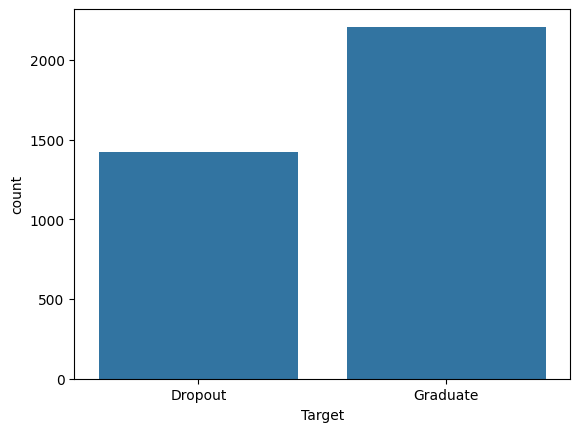

In [ ]:
sns.countplot(x='Target', data=df)
plt.show()

In [ ]:
col_numbers = ['apply_order', 'age_enroll', 'grade_1st', 'grade_2nd', 'unemployment', 'inflation', 'GDP']

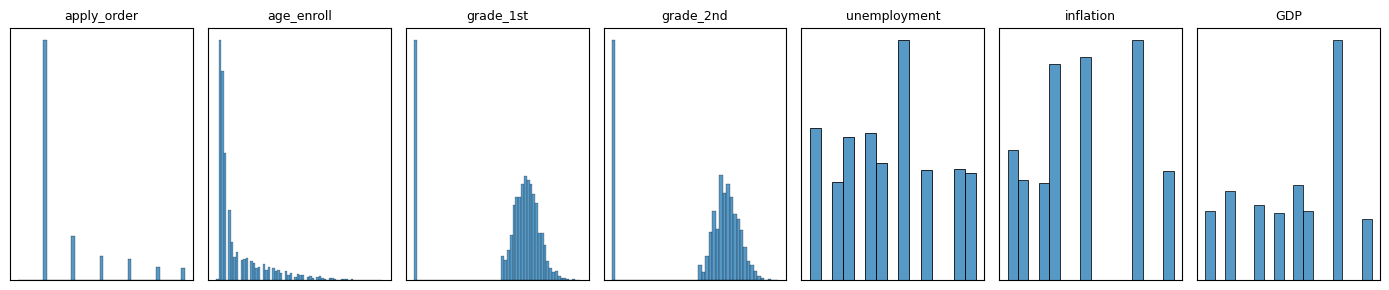

In [ ]:
def visual_ndata(numeric_columns):
  fig, axes = plt.subplots(1, len(numeric_columns), figsize=(14,3))

  for ax, var in zip(axes, numeric_columns):
      sns.histplot(df[var], ax=ax)
      ax.set_title(var, fontsize = 9)
      ax.set(xticks=[], yticks=[])
      # Remove x and y axis labels
      ax.set_xlabel('')
      ax.set_ylabel('')

  plt.tight_layout()
  plt.show()

visual_ndata(col_numbers)

# **4. Feature Engineering**

In [ ]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features = discrete_features, n_neighbors=10, random_state = 42)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [ ]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
discrete_features = X.dtypes == int
mi_scores = make_mi_scores(X, y, discrete_features=discrete_features)
mi_scores

,MI Scores
app_2nd,0.321941
app_1st,0.262771
grade_2nd,0.241846
grade_1st,0.197001
tuition_date,0.105286
eval_2nd,0.087086
eval_1st,0.080758
age_enroll,0.066501
Course,0.063603
apply_mode,0.054538


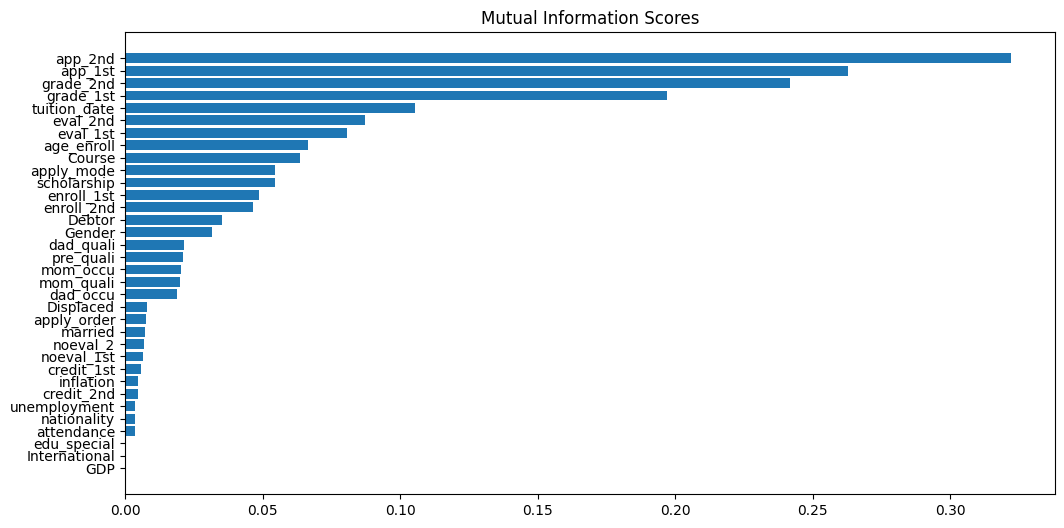

In [ ]:
import matplotlib.pyplot as plt
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(12, 6))
plot_mi_scores(mi_scores)

In [ ]:
col_chosen = list(mi_scores[mi_scores >= 0.01].index)
col_chosen

['app_2nd',
 'app_1st',
 'grade_2nd',
 'grade_1st',
 'tuition_date',
 'eval_2nd',
 'eval_1st',
 'age_enroll',
 'Course',
 'apply_mode',
 'scholarship',
 'enroll_1st',
 'enroll_2nd',
 'Debtor',
 'Gender',
 'dad_quali',
 'pre_quali',
 'mom_occu',
 'mom_quali',
 'dad_occu']

In [ ]:
X = X[col_chosen]
X

,app_2nd,app_1st,grade_2nd,grade_1st,tuition_date,eval_2nd,eval_1st,age_enroll,Course,apply_mode,scholarship,enroll_1st,enroll_2nd,Debtor,Gender,dad_quali,pre_quali,mom_occu,mom_quali,dad_occu
0,0,0,0.000000,0.000000,1,0,0,20,2,8,0,0,0,0,1,10,1,6,13,10
1,6,6,13.666667,14.000000,0,6,6,19,11,6,0,6,6,0,1,3,1,4,1,4
2,0,0,0.000000,0.000000,0,0,0,19,5,1,0,6,6,0,1,27,1,10,22,10
3,5,6,12.400000,13.428571,1,10,8,20,15,8,0,6,6,0,0,27,1,6,23,4
4,6,5,13.000000,12.333333,1,6,9,45,3,12,0,6,6,0,0,28,1,10,22,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,5,5,12.666667,13.600000,1,8,7,19,15,1,0,6,6,0,1,1,1,6,1,5
4420,2,6,11.000000,12.000000,0,6,6,18,15,1,0,6,6,1,0,1,1,10,1,10
4421,1,7,13.500000,14.912500,1,9,8,30,12,1,1,7,8,0,0,27,1,10,22,10
4422,5,5,12.000000,13.800000,1,6,5,20,9,1,1,5,5,0,0,27,1,8,22,5


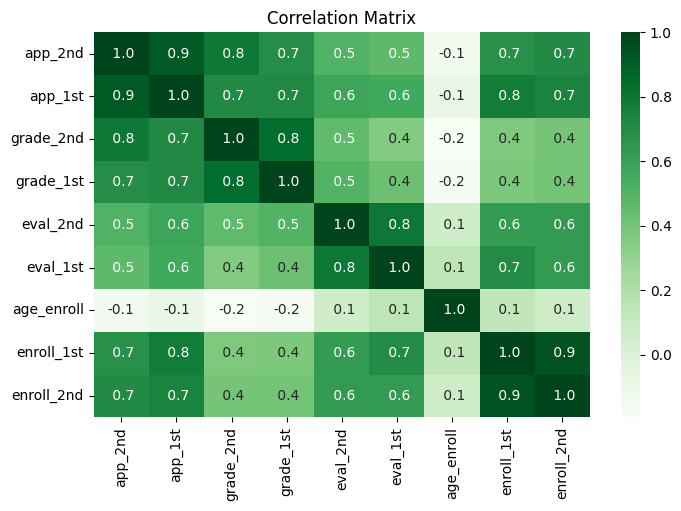

In [ ]:
numeric_var = ['app_2nd', 'app_1st', 'grade_2nd', 'grade_1st', 'eval_2nd', 'eval_1st','age_enroll', 'enroll_1st', 'enroll_2nd']
plt.figure(figsize=(8,5))
sns.heatmap(X[numeric_var].corr(), annot=True, cmap='Greens', fmt=' .1f')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
X['app_mean'] = (X['app_2nd'] + X['app_1st'])/2
X['grade_mean'] = (X['grade_2nd'] + X['grade_1st'])/2
X['eval_mean'] = (X['eval_2nd'] + X['eval_1st'])/2
X['enroll_mean'] = (X['enroll_2nd'] + X['enroll_1st'])/2
X = X.drop(['app_2nd', 'app_1st', 'grade_2nd', 'grade_1st', 'eval_2nd', 'eval_1st', 'enroll_2nd', 'enroll_1st'], axis = 1)
X

,tuition_date,age_enroll,Course,apply_mode,scholarship,Debtor,Gender,dad_quali,pre_quali,mom_occu,mom_quali,dad_occu,app_mean,grade_mean,eval_mean,enroll_mean
0,1,20,2,8,0,0,1,10,1,6,13,10,0.0,0.000000,0.0,0.0
1,0,19,11,6,0,0,1,3,1,4,1,4,6.0,13.833333,6.0,6.0
2,0,19,5,1,0,0,1,27,1,10,22,10,0.0,0.000000,0.0,6.0
3,1,20,15,8,0,0,0,27,1,6,23,4,5.5,12.914286,9.0,6.0
4,1,45,3,12,0,0,0,28,1,10,22,10,5.5,12.666667,7.5,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,19,15,1,0,0,1,1,1,6,1,5,5.0,13.133333,7.5,6.0
4420,0,18,15,1,0,1,0,1,1,10,1,10,4.0,11.500000,6.0,6.0
4421,1,30,12,1,1,0,0,27,1,10,22,10,4.0,14.206250,8.5,7.5
4422,1,20,9,1,1,0,0,27,1,8,22,5,5.0,12.900000,5.5,5.0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state = 42, stratify = y)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2904, 16)
(726, 16)
(2904,)
(726,)


In [ ]:
cate_var = ['tuition_date', 'Course', 'apply_mode', 'scholarship', 'Debtor', 'Gender', 'dad_quali', 'mom_quali', 'pre_quali', 'dad_occu', 'mom_occu']
cat_idx = [i for i, _ in enumerate(X.columns) if _ in cate_var]
print(cat_idx)

[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


In [ ]:
smote_nc = SMOTENC(categorical_features=cat_idx, random_state=42)
X_resampled, y_resampled = smote_nc.fit_resample(X_train, y_train)
X_resampled.shape

(3534, 16)

In [ ]:
encoder = TargetEncoder(cols=cate_var)
X_resampled[cate_var] = encoder.fit_transform(X_resampled[cate_var], y_resampled)
X_test[cate_var] = encoder.transform(X_test[cate_var])
X_resampled.head(5)

,tuition_date,age_enroll,Course,apply_mode,scholarship,Debtor,Gender,dad_quali,pre_quali,mom_occu,mom_quali,dad_occu,app_mean,grade_mean,eval_mean,enroll_mean
0,0.584956,19,0.393258,0.503311,0.829787,0.184149,0.594993,0.444231,0.490683,0.701577,0.544837,0.553846,6.0,14.083333,8.0,6.0
1,0.044964,49,0.212121,0.235142,0.403656,0.543639,0.336160,0.188983,0.523327,0.245162,0.187501,0.253522,0.0,0.000000,5.0,5.0
2,0.584956,19,0.716846,0.668491,0.403656,0.543639,0.594993,0.504868,0.523327,0.525564,0.515464,0.485441,6.0,11.488095,8.5,6.0
3,0.584956,18,0.750859,0.668491,0.829787,0.543639,0.594993,0.444231,0.523327,0.477811,0.424419,0.570248,7.0,13.381429,8.0,8.0
4,0.584956,44,0.582857,0.235142,0.403656,0.543639,0.594993,0.188983,0.361330,0.245162,0.187501,0.253522,7.0,13.125000,11.0,7.0


In [ ]:
y_resampled = y_resampled.map({'Dropout': 0, 'Graduate': 1})
y_test = y_test.map({'Dropout': 0, 'Graduate': 1})

# **5. Tunning Models**

In [ ]:
model_xgb = xgb.XGBClassifier(
    objective = 'binary:logistic',
    eval_metric = 'logloss',
    random_state = 42,
    n_jobs = -1
)

In [ ]:
params_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3,5,7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.5,0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0]
}

In [ ]:
xgb_tuning = GridSearchCV(estimator = model_xgb, param_grid = params_xgb, scoring = 'accuracy', cv = 5, n_jobs = -1, verbose = 1)
xgb_tuning.fit(X_resampled, y_resampled)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=-1, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.8, 1.0],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.5, 0.8, 1.0]},
             scoring='accuracy', verbose=1)

In [ ]:
print(xgb_tuning.best_params_)
print(xgb_tuning.best_score_)

{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
0.9165323695461411


In [ ]:
best_xgb = xgb_tuning.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
print("Accuracy:", acc_xgb)
print("Precision:", precision_xgb)
print("Recall:", recall_xgb)
print("F1 Score:", f1_xgb)

Accuracy: 0.90633608815427
Precision: 0.9047619047619048
Recall: 0.9457013574660633
F1 Score: 0.9247787610619469


<Figure size 800x600 with 0 Axes>

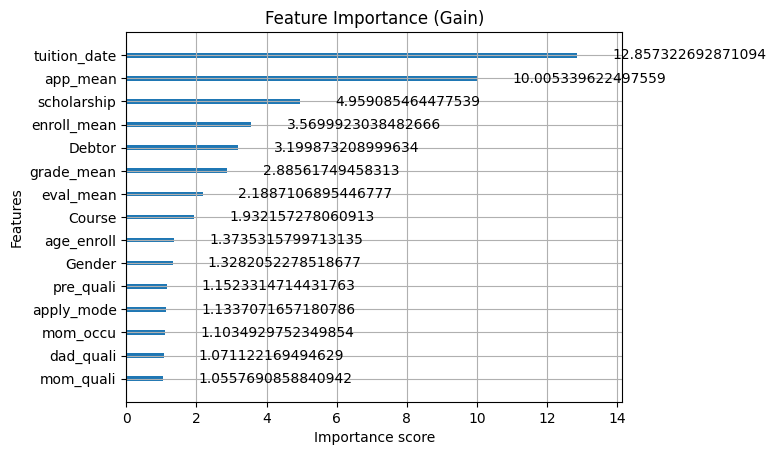

In [ ]:
plt.figure(figsize=(8, 6))
plot_importance(
    best_xgb,
    importance_type="gain",
    max_num_features=15
)
plt.title("Feature Importance (Gain)")
plt.show()

In [ ]:
rf = RandomForestClassifier(random_state = 42, n_jobs = -1)

In [ ]:
params_rf = {
    'n_estimators': [100,200,300],
    'max_depth': [3,5,7],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1,2,4],
    'max_features': ['sqrt', 'log2']
}

In [ ]:
rf_tuning = GridSearchCV(estimator=rf, param_grid=params_rf, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
rf_tuning.fit(X_resampled, y_resampled)
print(rf_tuning.best_params_)
print(rf_tuning.best_score_)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
{'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
0.9037949120691107


In [ ]:
best_rf = rf_tuning.best_estimator_
y_pred_rf = best_rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
print("Accuracy:", acc_rf)
print("Precision:", precision_rf)
print("Recall:", recall_rf)
print("F1 Score:", f1_rf)

Accuracy: 0.9022038567493113
Precision: 0.9006479481641468
Recall: 0.9434389140271493
F1 Score: 0.9215469613259668


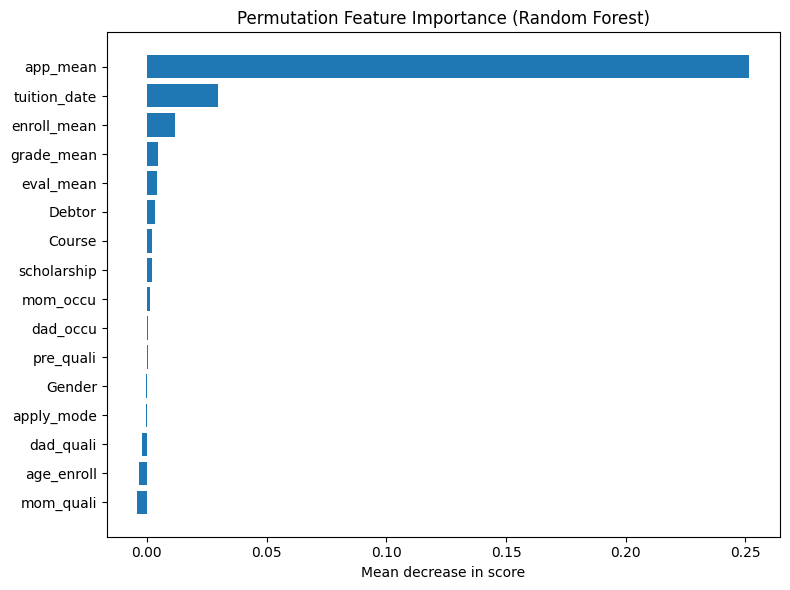

In [ ]:
r = permutation_importance(
    best_rf,
    X_test, y_test,
    n_repeats=10,
    random_state=42,
    scoring="accuracy"
)
fi_perm = pd.Series(
    r.importances_mean,
    index=X_test.columns
).sort_values(ascending=False)

plt.figure(figsize=(8, 6))
plt.barh(fi_perm.index[::-1], fi_perm.values[::-1])
plt.xlabel("Mean decrease in score")
plt.title("Permutation Feature Importance (Random Forest)")
plt.tight_layout()
plt.show()

In [ ]:
dict_perform = {
    'Model': ['XGBoost', 'Random Forest'],
    'Accuracy': [acc_xgb, acc_rf],
    'Precision': [precision_xgb, precision_rf],
    'Recall': [recall_xgb, recall_rf],
    'F1 Score': [f1_xgb, f1_rf]
}
df_perform = pd.DataFrame(dict_perform)
df_perform

,Model,Accuracy,Precision,Recall,F1 Score
0,XGBoost,0.906336,0.904762,0.945701,0.924779
1,Random Forest,0.902204,0.900648,0.943439,0.921547


In [ ]:
df_long = df_perform.melt(
    id_vars="Model",
    var_name="Metric",
    value_name="Score"
)

df_long

,Model,Metric,Score
0,XGBoost,Accuracy,0.906336
1,Random Forest,Accuracy,0.902204
2,XGBoost,Precision,0.904762
3,Random Forest,Precision,0.900648
4,XGBoost,Recall,0.945701
5,Random Forest,Recall,0.943439
6,XGBoost,F1 Score,0.924779
7,Random Forest,F1 Score,0.921547


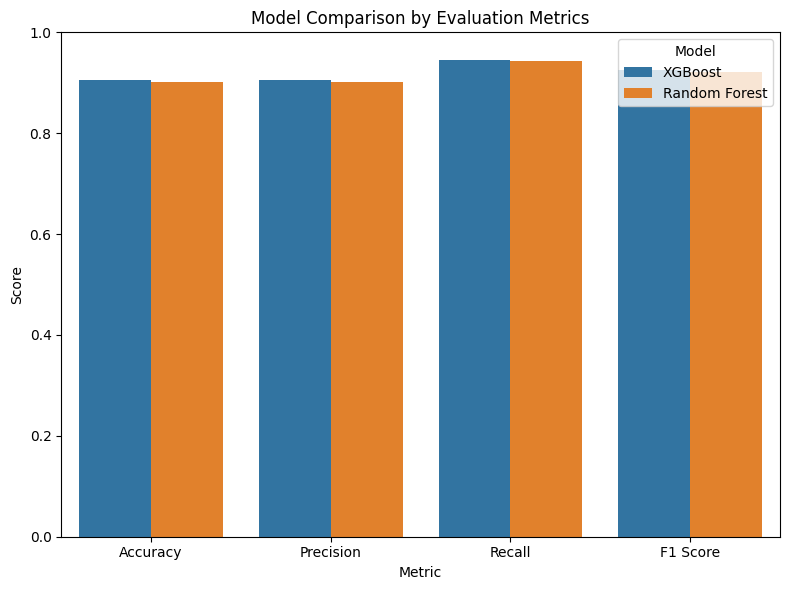

In [ ]:
plt.figure(figsize=(8, 6))

sns.barplot(
    data=df_long,
    x="Metric",
    y="Score",
    hue="Model"
)

plt.ylim(0, 1)
plt.title("Model Comparison by Evaluation Metrics")
plt.ylabel("Score")
plt.xlabel("Metric")
plt.legend(title="Model")
plt.tight_layout()
plt.show()